In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
import pandas as pd
df=pd.read_csv('train.csv')

In [3]:
X=df.drop(['yield', 'id', 'Row#'],axis=1)
y=df['yield']
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pickle

In [4]:
class HigherOrderRegressor():
    def __init__(self, degree):
        self.degree = degree
        self.X = None
        self.Y = None
        self.B = None
        self.num_features = None

    def fit(self, X, Y):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)
        self.num_features=X.shape[1]
        indices=np.random.shuffle(np.arange(X.shape[0]))
        temp_X = X[indices][0]
        temp_Y = Y[indices][0]
        # np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        self.orig_X = np.hstack((np.ones((X.shape[0], 1)), temp_X))
        self.Y = temp_Y
        self.X = self.recursive_generate_powers(0, self.degree, np.ones(X.shape[0])).T
        try:
            self.B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)),
                                np.matmul(self.X.T, self.Y))
        except:
            self.B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)),
                                np.matmul(self.X.T, self.Y))

    def recursive_generate_powers(self, max_feature_encountered, current_degree, current_product, use_orig=True):
        if current_degree == 0:
            return current_product
        result=[]
        for i in range(max_feature_encountered, self.num_features+1):
            if use_orig:
                result.append(self.recursive_generate_powers(i, current_degree-1,
                                                            current_product*self.orig_X[:,i]))
            else:
                result.append(self.recursive_generate_powers(i, current_degree-1,
                                                            current_product*self.test_X[:,i], False))
        result=np.vstack(result)
        return result
    
    def predict(self, X):
        if X.ndim == 1:
            X = X.reshape(-1,1)
        self.test_X=np.hstack((np.ones((X.shape[0], 1)), X))
        self.final_testX=self.recursive_generate_powers(0, self.degree, np.ones(X.shape[0]), False).T
        return np.matmul(self.final_testX, self.B)

    def sum_of_squares(self, Y_true, Y_pred):
        return np.sum((Y_true - Y_pred)**2)
        
    def r2_score(self, Y_true, Y_pred):
        return 1 - np.sum((Y_true - Y_pred)**2) / np.sum((Y_true - np.mean(Y_true))**2)

    def k_fold_testing(self, k=10):
        width = self.X.shape[0]//k
        average_r2 = 0
        count = 0
        for i in range(0, self.X.shape[0], k):
            count += 1
            X_train = np.concatenate((self.X[:i], self.X[i+width:]))
            Y_train = np.concatenate((self.Y[:i], self.Y[i+width:]))
            X_test = self.X[i:i+width]
            Y_test = self.Y[i:i+width]
            try:
                B = np.matmul(np.linalg.pinv(np.matmul(X_train.T, X_train)), np.matmul(X_train.T, Y_train))
            except:
                B = np.matmul(np.linalg.pinv(np.matmul(X_train.T, X_train)), np.matmul(X_train.T, Y_train))
            predictions = np.matmul(X_test, B)
            average_r2 += self.r2_score(Y_test, predictions)
        # print(self.X.shape)
        try:
            B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)), np.matmul(self.X.T, self.Y))
        except:
            B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)), np.matmul(self.X.T, self.Y))
        return average_r2/count, np.matmul(self.X, B)
    
    def cross_validation(self, params):
        maximum_param=np.max(params)
        self.max_X=self.recursive_generate_powers(0, maximum_param, np.ones(self.X.shape[0])).T
        # print(self.max_X)
        responses = []
        factorials=[1]
        for i in range(1, maximum_param+self.num_features+1):
            factorials.append(factorials[-1]*i)
        for param in params:
            self.degree = param
            # print((factorials[param+self.num_features]//factorials[self.num_features])//factorials[param])
            self.X=self.max_X[:,:(factorials[param+self.num_features]//factorials[self.num_features])//factorials[param]]
            response, plot_values = self.k_fold_testing()
            responses.append(response)
            fig=plt.figure()
            plt.scatter(self.orig_X[:,1], self.Y)
            indices=np.argsort(self.orig_X[:,1])
            plt.plot(self.orig_X[:,1][indices], plot_values[indices], 'red')
            fig.savefig(f"degree_{param}.png")
        print(responses)
    
    def write_params(self):
        with open("3_weights.pkl", "wb") as f:
            pickle.dump(self.B, f)


In [5]:
reg=HigherOrderRegressor(1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

In [7]:
from tqdm import tqdm
import numpy as np

In [89]:
errors=[]
for i in tqdm(range(1, 2**12)):
    mask = np.array(list(np.binary_repr(16*i+14, width=16)), dtype=int).astype(bool)
    X_train2=X_train[:,mask]
    X_test2=X_test[:,mask]
    X_train2=PolynomialFeatures(degree=4).fit_transform(X_train2)
    X_test2=PolynomialFeatures(degree=4).fit_transform(X_test2)
    reg.fit(X_train2, y_train)
    errors.append(mean_absolute_error(y_test, reg.predict(X_test2)))

 61%|██████    | 2496/4095 [31:03<19:53,  1.34it/s]  


KeyboardInterrupt: 

In [85]:
errors=[]
for i in tqdm(range(0, 2**12)):
    mask = np.array(list(np.binary_repr(16*i+7, width=16)), dtype=int).astype(bool)
    X_train2=X_train[:,mask]
    X_test2=X_test[:,mask]
    X_train2=PolynomialFeatures(degree=4).fit_transform(X_train2)
    X_test2=PolynomialFeatures(degree=4).fit_transform(X_test2)
    reg.fit(X_train2, y_train)
    errors.append(mean_absolute_error(y_test, reg.predict(X_test2)))


100%|██████████| 4096/4096 [52:11<00:00,  1.31it/s]  


In [102]:
print(np.min(errors))

273.65912119079286


In [103]:
print(np.argmin(errors))

3


In [137]:
input=pd.read_csv('test.csv').iloc[0]
input=input.drop(['id', 'Row#'])
input=PolynomialFeatures(degree=4).fit_transform(input.values.reshape(1, -1))
for i in [5535, 119, 247, 127, 5536, 46941, 118, 119, 2613, 9055, 9056, 46940, 14407, 14343, 41823]:
    mask = np.array(list(np.binary_repr(i, width=16)), dtype=int).astype(bool)
    output=4544.450218043385
    X_train2=X_train[:,mask]
    X_test2=X_test[:,mask]
    X_train2=PolynomialFeatures(degree=4).fit_transform(X_train2)
    X_test2=PolynomialFeatures(degree=4).fit_transform(X_test2)
    reg.fit(X_train2, y_train)
    pred=reg.predict(input)
    if abs(pred-output)< 1e-3:
        print(i)
        break

In [126]:
mask = np.array(list(np.binary_repr(20483, width=16)), dtype=int).astype(bool)
X_train_final=X.values[:,mask]
X_train_final_2=PolynomialFeatures(degree=4).fit_transform(X_train_final)
reg.fit(X_train_final, y.values)
test_data=pd.read_csv('test.csv')
X_test_final=test_data.drop(['id', 'Row#'], axis=1).values[:,mask]
X_test_final_2=PolynomialFeatures(degree=4).fit_transform(X_test_final)
y_pred=reg.predict(X_test_final)
test_data['yield']=y_pred
test_data[['id', 'yield']].to_csv('hello.csv', index=False)

In [119]:
orig_preds=pd.read_csv('output.csv')
new_preds=pd.read_csv('hello.csv')
mean_absolute_error(orig_preds['yield'], new_preds['yield'])

100.61841233745739

In [13]:
X_trainfinal=PolynomialFeatures(degree=4).fit_transform(X.values[:,mask])
y_trainfinal=y.values

In [14]:
reg.fit(X_trainfinal, y_trainfinal)

<Axes: >

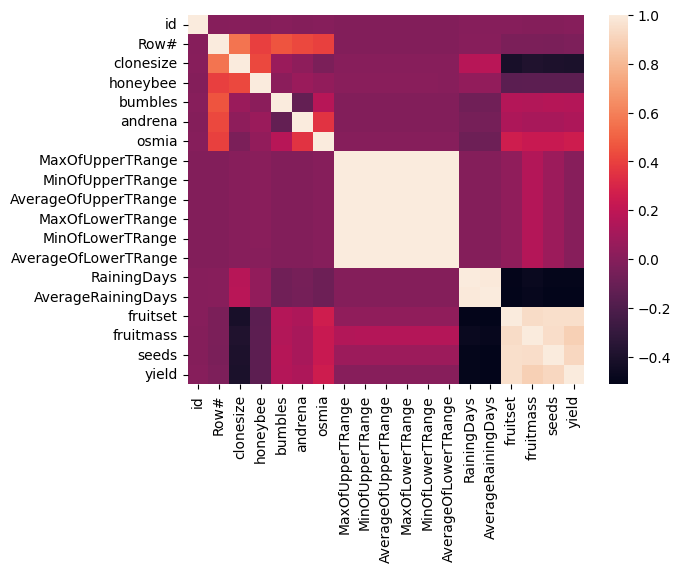

In [9]:
from seaborn import heatmap
heatmap(df.corr())

In [33]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
mask = np.array(list(np.binary_repr(5535, width=16)), dtype=int).astype(bool)
X_train2=PolynomialFeatures(degree=3).fit_transform(X_train[:,mask])
X_test2=PolynomialFeatures(degree=3).fit_transform(X_test[:,mask])
estimator = LinearRegression()

rfecv = RFECV(
    estimator=estimator, 
    step=1,  
    cv=5,    # Number of folds in cross-validation
    scoring='neg_mean_absolute_error'  # Metric to evaluate the model
)

# Fit RFECV to the training data
rfecv.fit(X_train2, y_train)

# Plot the number of features vs. cross-validation score
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross-validation score (neg_mean_squared_error)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

# Print the optimal number of features
print("Optimal number of features: %d" % rfecv.n_features_)

# Get the selected features
selected_features = rfecv.support_
print("Selected features (True means feature is selected):", selected_features)

# Transform the training data to only use the selected features
X_train_transformed = rfecv.transform(X_train2)
X_test_transformed = rfecv.transform(X_test2)

# Evaluate the performance on the test set
model = estimator.fit(X_train_transformed, y_train)
test_score = mean_absolute_error(y_test, model.predict(X_test_transformed))
print("Test score with selected features:", test_score)


Optimal number of features: 6
Selected features (True means feature is selected): [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True False False False False False
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False

In [41]:
X_train2=PolynomialFeatures(degree=4).fit_transform(X_train[:,mask])[:,rfecv.support_]
X_test2=PolynomialFeatures(degree=4).fit_transform(X_test[:,mask])[:,rfecv.support_]
reg.fit(X_train2, y_train)
mean_absolute_error(y_test, reg.predict(X_test2))

AttributeError: 'RFECV' object has no attribute 'support_'

In [32]:
test_data=pd.read_csv('test.csv')   
X_test_final=test_data.drop(['id', 'Row#'],axis=1)
X_test_final=X_test_final.values[:,mask]
X_test_final=PolynomialFeatures(degree=4).fit_transform(X_test_final)
X_test_final=X_test_final[:,rfecv.support_]
reg.fit(PolynomialFeatures(degree=4).fit_transform(X.values[:,mask])[:,rfecv.support_], y.values)
y_pred=reg.predict(X_test_final)

In [33]:
test_data['yield']=y_pred
test_data[['id', 'yield']].to_csv('hello.csv', index=False)

In [35]:
orig_preds=pd.read_csv('output.csv')
print(mean_absolute_error(orig_preds['yield'], y_pred))

278.61173192147885


In [ ]:
rfecv.support_

In [78]:
%history


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filen

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# Initialize the model
reg = HigherOrderRegressor(1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to NumPy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Load the test data
test_data = pd.read_csv('test.csv')

# Create a bitmask to select specific features
mask = np.array(list(np.binary_repr(119, width=16)), dtype=int).astype(bool)

# Apply the bitmask to select features in the training and test sets
X_train_masked = X_train[:, mask]
X_test_masked = X_test[:, mask]

# Transform the features using a polynomial transformation of degree 4
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train_masked)
X_test_poly = poly.fit_transform(X_test_masked)

# Fit the model with the transformed training data
reg.fit(X_train_poly, y_train)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, reg.predict(X_test_poly))
print(f'Mean Absolute Error: {mae}')

# Process the test data for final predictions
X_test_final = test_data.drop(['id', 'Row#'], axis=1).values[:, mask]
X_test_final_poly = poly.fit_transform(X_test_final)

# Fit the model to the complete training set
X_train_full_poly = poly.fit_transform(X.values[:, mask])
y_train_full = y.values
reg.fit(X_train_full_poly, y_train_full)

# Make predictions on the final test data
test_data['yield'] = reg.predict(X_test_final_poly)

# Create a new DataFrame with the predictions and save to CSV
output = test_data[['id', 'yield']]
output.to_csv('hello.csv', index=False)


Mean Absolute Error: 261.28355604628484


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new=PolynomialFeatures(degree=4).fit_transform(X_train.values[:,mask])
X_test_new=PolynomialFeatures(degree=4).fit_transform(X_test.values[:,mask])
min_error=261.28355604628484
reg.fit(X_train_new, y_train.values)   
indices_of_significance = np.argsort(np.abs(reg.B[:,0]))[-20:][::-1]
# indices_of_significance = np.random.choice(np.arange(len(reg.B[:,0])), 20, replace=False)
print(indices_of_significance)

errors=[]
for i in tqdm(range(0, 2**20)):
    indices_mask = np.array(list(np.binary_repr(i, width=20)), dtype=int).astype(bool)
    new_indices_of_significance=indices_of_significance[indices_mask]
    new_mask=[i for i in range(X_train_new.shape[1]) if i not in new_indices_of_significance]
    
    # new_mask = np.array(list(np.binary_repr((2**X_train_new.shape[1] - 1) - sum(2**i for i in new_indices_of_significance), 
    #                                    width=X_train_new.shape[1])), dtype=int).astype(bool)
    X_train_new_2=X_train_new[:,new_mask]
    X_test_new2=X_test_new[:,new_mask]
    reg.fit(X_train_new_2, y_train.values)
    errors.append(mean_absolute_error(y_test, reg.predict(X_test_new2)))
    # print(errors[-1])
    # print(X_train_new_2.shape)
    if errors[-1] < min_error:
        min_error=errors[-1]
        print(i, min_error)

[ 80  61  46  53  28 201  38 160 150  18 114  94  89 144  73 104 120  97
 111  71]


  0%|          | 71/1048576 [00:05<22:16:38, 13.07it/s]

69 261.12755288141886


  0%|          | 3975/1048576 [05:01<22:49:48, 12.71it/s]

3973 261.0986956304425


  1%|▏         | 14404/1048576 [18:01<20:27:20, 14.04it/s]

14402 261.08390999188936


  2%|▏         | 18823/1048576 [23:37<17:00:50, 16.81it/s]

18819 261.0750457550168


  3%|▎         | 35590/1048576 [44:07<21:20:39, 13.18it/s]

35587 261.05418542697106


 11%|█         | 110872/1048576 [2:21:57<13:59:46, 18.61it/s] 

110867 261.0365165110958


 11%|█▏        | 118154/1048576 [2:31:49<35:20:19,  7.31it/s] 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new=PolynomialFeatures(degree=4).fit_transform(X_train.values[:,mask])
X_test_new=PolynomialFeatures(degree=4).fit_transform(X_test.values[:,mask])
min_error=261.28355604628484
errors=[]
test_data=pd.read_csv('test.csv')
X_test_final=test_data.drop(['id', 'Row#'], axis=1).values[:,mask]
X_train_final_2=PolynomialFeatures(degree=4).fit_transform(X.values[:,mask])
X_test_final_2=PolynomialFeatures(degree=4).fit_transform(X_test_final)
new_mask = np.array(list(np.binary_repr(2**X_train_final_2.shape[1]-1-3712, width=X_train_final_2.shape[1])), dtype=int).astype(bool)
reg.fit(X_train_final_2[:,new_mask], y.values)
# print(X_train_final_2[:,new_mask].shape, X_test_final_2[:,new_mask].shape)    
X_test_final_2=X_test_final_2[:,new_mask]
y_pred=reg.predict(X_test_final_2)
print(mean_absolute_error(pd.read_csv('output.csv')['yield'], y_pred))
test_data['yield']=y_pred
test_data[['id', 'yield']].to_csv('hello.csv', index=False)

34.448078090796066


In [28]:
print(np.argsort(np.abs(reg.B[:,0]))[-20:][::-1])

[ 80  61  46  53  28 201  38 160 150  18 114  94  89 144  73 104 120  97
 111  71]


In [24]:
print(np.argmax(np.abs(reg.B)))

80
